In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.linalg import svd, orth, qr
from scipy.optimize import curve_fit
from numpy import sin, cos, pi
cmap = plt.cm.plasma

In [2]:
from initial_conditions import Domain, Heaviside, LinearRamp, SmoothRamp, Sigmoid, CkRamp
from basis_functions import SVD, Trigonometric, Trigonometric2, TrigonometricOdd, Greedy, LNA, LPF, Sinc, Fourier

In [3]:
page_width_pt = 455.24
pt2in = 0.01389 
pt2cm = 0.0352777778
cm2in = 1/2.54
plot_width_in = page_width_pt*pt2in/2
print(plot_width_in/cm2in)

plt.rcParams["figure.figsize"] = (plot_width_in, plot_width_in/1.61803398875)
plt.rcParams['font.size'] = 12
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
#mpl.rc('text', usetex=True)
mpl.rc('font', family='serif', size=12, serif='Computer Modern Roman')
pth = "C:/Users/florianma/Dropbox/Kol-N-width-Oslo-Ulm/Plots/"

8.030570172000001


In [4]:
m, n = 2500, 2500
x = Domain([0, 1], m)
mu = Domain([0, 1], n)

r = min(m, n)
i = np.arange(0, r)

In [5]:
u_hs = Heaviside()
X = u_hs(x(), mu())

X[np.abs(X)<1e-6] = 1.0

In [6]:
trig_basis_odd = TrigonometricOdd(x())
d_N, S = trig_basis_odd.calc_error_analytic(X)

In [7]:
d_N_low_res = {}
for m_ in np.arange(1000, 11000, 1000):
    n_ = m_
    print(m_)
    x = Domain([0, 1], m_)
    mu = Domain([0, 1], n_)
    X_ = u_hs(x(), mu())
    X_[np.abs(X_)<1e-6] = 1.0
    trig_basis_odd_ = TrigonometricOdd(x())
    d_N, S = trig_basis_odd_.calc_error_analytic(X_)
    d_N_low_res[m_] = d_N

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000


In [8]:
def sort_trig_basis(trig_basis_odd, X, PLOT=True):
    V_k = trig_basis_odd.U.reshape(m, -1, 2)  # x, r, 2
    V_1 = V_k[:, :, 0].copy()  # sin
    c = V_1.T @ X  # V_1.T @ X is slow!
    c_n = (c**2).sum(axis=1)
    order = np.argsort(-c_n)
    if PLOT:
        V_1 = V_k[:, :, 1].copy()  # sin
        c2 = V_1.T @ X  # V_1.T @ X is slow!
        c_n2 = (c**2).sum(axis=1)
        fig, ax = plt.subplots()
        ax.plot(trig_basis_odd.frequencies, c_n**.5, ".", ms=1)
        ax.plot(trig_basis_odd.frequencies, c_n2**.5, ".", ms=1)
        ax.set_yscale('log')
        plt.show()
    trig_basis_odd.U = V_k[:, order, :].reshape(m, -1)
    trig_basis_odd.frequencies = trig_basis_odd.frequencies[order]
    return None

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman


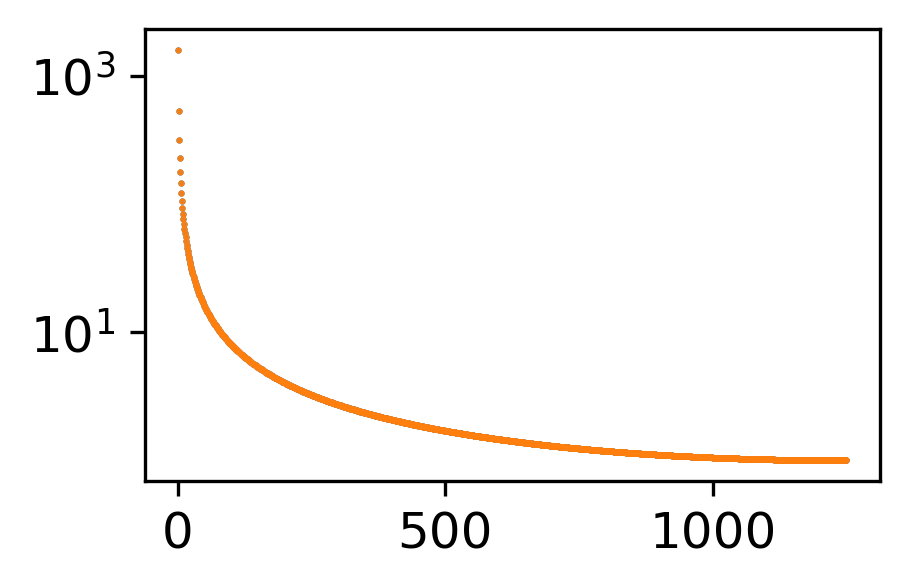

In [9]:
sort_trig_basis(trig_basis_odd, X)

In [10]:
r = 5000
N = np.arange(1, r+1)
floor_kp1 = (2*np.floor((np.arange(500000000)+1)/2, dtype=np.float64)-1) # higher prcision is important here
d_N_exact = (4/np.pi**2 * np.cumsum((floor_kp1**-2)[::-1])[::-1][:r])**.5
print(d_N_exact.shape)

(5000,)


1000
1000 (1000,) (1000,)
2000
2000 (2000,) (2000,)
3000
3000 (3000,) (3000,)
4000
4000 (4000,) (4000,)
5000
5000 (5000,) (5000,)
6000
6000 (6000,) (6000,)
7000
7000 (7000,) (7000,)
8000
8000 (8000,) (8000,)
9000
9000 (9000,) (9000,)
10000
10000 (10000,) (10000,)
attempting to save


C:\Users\florianma\AppData\Local\Temp\ipykernel_25812\1656550140.py:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  ax.plot(Nn[1::p], d_N[1::p], "b-", label=lbl, ms=1, color=color)
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman


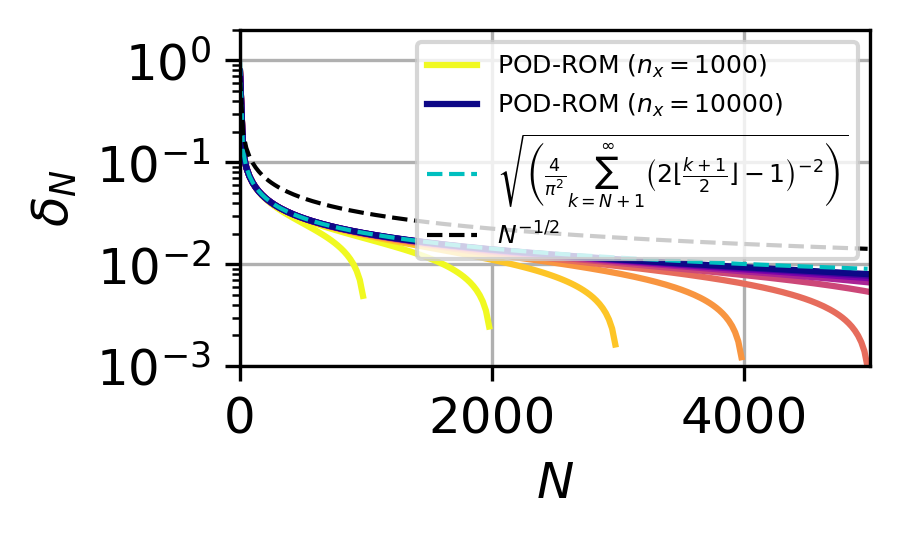

5000


In [11]:
lbl1 = r'$2*\sqrt {\left( \frac{2}{N \pi^2} \right)}$'
lbl2 =  r'$2 \sqrt {\left( \frac{1}{2} - \frac{4}{\pi^2} \sum_{i=1}^N  \frac{1}{(2i-1)^2 } \right)}$'
lbl3 =  r'$\sqrt {\left(  \sum_{k=N+1}^\infty  \frac{8}{(2k-1)^2 \pi^2} \right)}$'

lbl_new =  r'$\sqrt{\left(  \frac{4}{\pi^2}  \sum_{k=N+1}^\infty \left(2 \lfloor \frac{k+1}{2} \rfloor - 1 \right)^{-2}\right)}$'
decay_exact_old = 2*(1/2 - 4/np.pi**2*np.cumsum(1/(2*N-1)**2))**.5
decay_estimate = (2/(N*np.pi**2))**.5

#t = 8/ ((2*k-1)**2*np.pi**2 )
#res = np.cumsum(t[::-1])[::-1]
#decay_new = res[i]**.5

p = 25

fig, ax = plt.subplots()
#ax.plot(N, d_N, "b.", ms=1, label="POD-ROM")
i = 9
for key, val in d_N_low_res.items():
    print(key)
    color = cmap(i/8)
    i -= 1
    Nn = np.arange(1, key+1)
    d_N = val
    if key in [1000, 10000]:
        lbl = "POD-ROM ($n_x={:.0f}$)".format(key)
    else:
        lbl = None
    print(key, Nn.shape, d_N.shape)
    ax.plot(Nn[1::p], d_N[1::p], "b-", label=lbl, ms=1, color=color)

#ax.plot(Nn, d_N, "b.", ms=1, label="POD-ROM (a={:.0f})".format(key), color=color)
ax.plot(N[1::p], d_N_exact[1::p], "c--", label=lbl_new, lw=1)
#ax.plot(N, decay_exact_old, "r--", label=lbl2, lw=1)
#ax.plot(i, decay_estimate, "g--", label=lbl1, lw=1)
#ax.plot(N, decay_new, "b--", label=lbl3, lw=1)
ax.plot(N[1::p], N[1::p]**-.5, "k--", label=r'$N^{-1/2}$', lw=1) # too high?
#ax.plot(N, 1/2*N**-.5, "c--", label=r'$\frac{1}{2}N^{-1/2}$', lw=1)


ax.set_yscale('log')
plt.legend(prop={'size': 6})
plt.xlabel(r'$N$')
plt.ylabel(r'$\delta_N$')
ax.set_xlim([0, r])
ax.set_ylim([1e-3, 2])
plt.grid()
print("attempting to save")
plt.tight_layout()
plt.savefig(pth+"error_heaviside_new.pdf")
plt.show()
print(r)

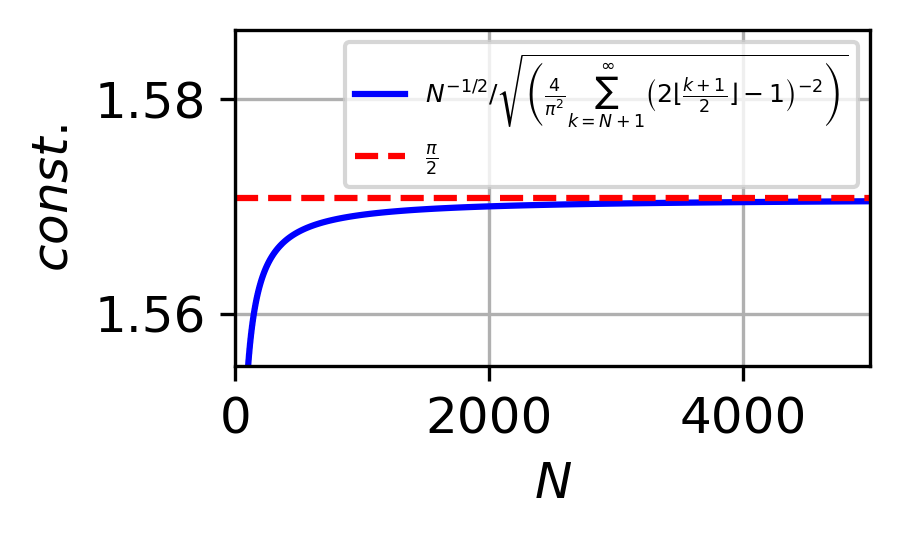

1.5707964570634942
1.5707963267948966


In [12]:
p = 1
plt.plot(N[::p], (N**-.5/d_N_exact)[::p], "b-", ms=1, label=r'$N^{-1/2}/$'+lbl_new)
#plt.plot(N**-.5/decay_exact_old, "g.", ms=1, label=r'$N^{-1/2}/$'+lbl2)
plt.plot([0, r], [np.pi/2, np.pi/2], "r--", ms=1, label=r'$\frac{\pi}{2}$')
#plt.xlim([0, 100])
plt.ylim([np.pi/2 * .99, np.pi/2 * 1.01])
plt.legend(prop={'size': 6})
plt.xlabel(r'$N$')
plt.ylabel(r'$const.$')
plt.xlim([0, r])
plt.grid()
plt.tight_layout()
plt.savefig(pth+"estimate_HS.pdf")
plt.show()
print((N**-.5/decay_exact_old)[100:].mean())
print(np.pi/2)

calc_error: 2500 2500 2500
2, 

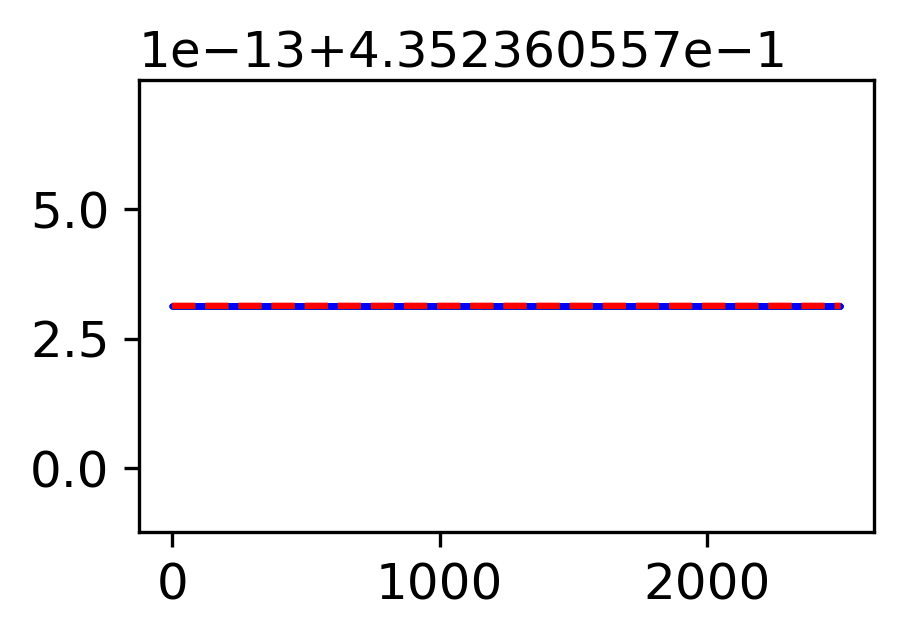

26, 50, 74, 98, 122, 146, 170, 194, 218, 242, 266, 290, 314, 338, 362, 386, 410, 434, 458, 482, 506, 530, 554, 578, 602, 626, 650, 674, 698, 722, 746, 770, 794, 818, 842, 866, 890, 914, 938, 962, 986, 1010, 1034, 1058, 1082, 1106, 1130, 1154, 1178, 1202, 1226, 1250, 1274, 1298, 1322, 1346, 1370, 1394, 1418, 1442, 1466, 1490, 1514, 1538, 1562, 1586, 1610, 1634, 1658, 1682, 1706, 1730, 1754, 1778, 1802, 1826, 1850, 1874, 1898, 1922, 1946, 1970, 1994, 2018, 2042, 2066, 2090, 2114, 2138, 2162, 2186, 2210, 2234, 2258, 2282, 2306, 2330, 2354, 2378, 2402, 2426, 2450, 2474, 2498, calc_error: 2500 2500 2500
2, 

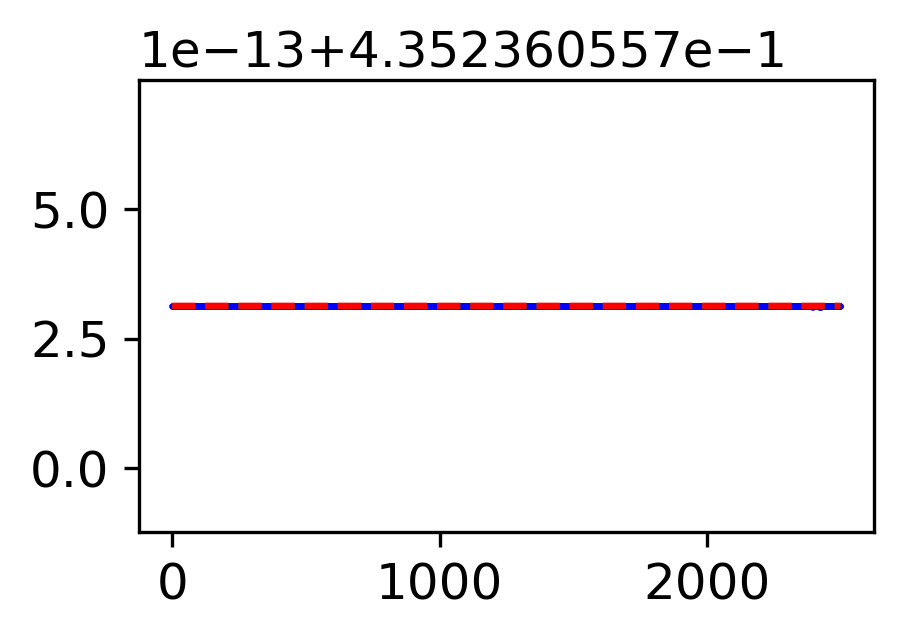

26, 50, 74, 98, 122, 146, 170, 194, 218, 242, 266, 290, 314, 338, 362, 386, 410, 434, 458, 482, 506, 530, 554, 578, 602, 626, 650, 674, 698, 722, 746, 770, 794, 818, 842, 866, 890, 914, 938, 962, 986, 1010, 1034, 1058, 1082, 1106, 1130, 1154, 1178, 1202, 1226, 1250, 1274, 1298, 1322, 1346, 1370, 1394, 1418, 1442, 1466, 1490, 1514, 1538, 1562, 1586, 1610, 1634, 1658, 1682, 1706, 1730, 1754, 1778, 1802, 1826, 1850, 1874, 1898, 1922, 1946, 1970, 1994, 2018, 2042, 2066, 2090, 2114, 2138, 2162, 2186, 2210, 2234, 2258, 2282, 2306, 2330, 2354, 2378, 2402, 2426, 2450, 2474, 2498, 

In [14]:
svd_basis = SVD(X)
r = min(m, n)
results = np.zeros((3, 2, r))
for i, basis in enumerate([trig_basis_odd, svd_basis]):
    delta_n, d_n = basis.calc_error(X, r)
    delta_N2, S = basis.calc_error_analytic(X)
    results[0, i, :] = delta_n
    results[1, i, :] = d_n
    results[2, i, :] = delta_N2[:r]

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman


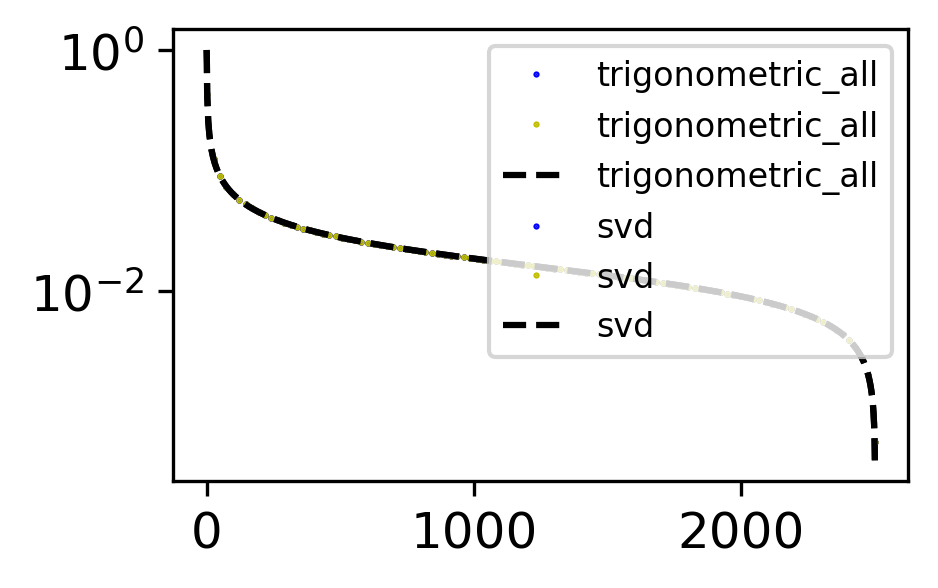

In [15]:
fig, ax = plt.subplots()
for i, basis in enumerate([trig_basis_odd, svd_basis]):
    ax.plot(results[0, i, :], "b.", ms=1, label=basis.name)
    ax.plot(results[1, i, :], "y.", ms=1, label=basis.name)
    ax.plot(results[2, i, :], "k--", label=basis.name)
ax.set_yscale('log')
plt.legend(prop={'size': 8})
plt.show()